Сегодняшний проект посвящен компании «Мегалайн» — федерального оператора сотовой связи. Они предлагают клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Обзор данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
import math as mt
from scipy.stats import norm
from scipy import stats as st
import scipy.stats

Первым делом импортируем наши датасеты и выведем информацию о них на экран.

In [2]:
try:
    users = pd.read_csv('C:/Users/annya/Downloads/users.csv')
    tariffs = pd.read_csv('C:/Users/annya/Downloads/tariffs.csv')
    messages = pd.read_csv('C:/Users/annya/Downloads/messages.csv')
    internet = pd.read_csv('C:/Users/annya/Downloads/internet.csv')
    calls = pd.read_csv('C:/Users/annya/Downloads/calls.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    calls = pd.read_csv('/datasets/calls.csv')

In [3]:
print(users.info())
print(tariffs.info())
print(messages.info())
print(internet.info())
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-

Первое, что мы можем отметить - отсутствие пропусков в наших датасетах, а это не может не радовать. Единственный пропуск замечен в users в столбце churn_date, он хранит в себе дату окончания действия тарифа, а NaN означает, что тариф всё ещё используется. Поэтому прежде чем начинать обработку дубликатов и дальнейшее исследование, избавимся от пропусков в этом столбце, заменив их на 0. Также мы видим колонку Unnamed: 0 в internet, который просто дублирует наши индексы. Удалим его, чтобы не путаться. И наконец переименует колонку tariff_name для того, чтобы в дальнейшем на её основе можно было соединять её с другими датасетами.

In [4]:
users['churn_date'] = users['churn_date'].fillna(0)
internet.pop('Unnamed: 0')
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

Теперь выведем по 5 первых строк из каждого датафрейма.

In [5]:
display(users.head())
display(tariffs.head())
display(messages.head())
display(internet.head())
calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,0,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,0,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Отлично, теперь перерходим к предобработке наших данных. Наша задачи заменить типы, исправить ошибки, удалить дубликаты.

## Шаг 2. Подготовка и предобработка данных

Первым делом найдём явные дубликаты в каждом датасете.

In [6]:
print(users.duplicated().sum())
print(tariffs.duplicated().sum())
print(messages.duplicated().sum())
print(internet.duplicated().sum())
calls.duplicated().sum()

0
0
0
0


0

Теперь поищем неявные дубликаты в тех столбцах, где они могут встречаться.

In [7]:
print(users['city'].unique())
print(users['tariff'].unique())
tariffs['tariff'].unique()

['Краснодар' 'Москва' 'Стерлитамак' 'Новокузнецк' 'Набережные Челны'
 'Ульяновск' 'Челябинск' 'Пермь' 'Тюмень' 'Самара' 'Санкт-Петербург'
 'Иваново' 'Чебоксары' 'Омск' 'Уфа' 'Томск' 'Чита' 'Мурманск'
 'Петрозаводск' 'Тверь' 'Екатеринбург' 'Махачкала' 'Вологда' 'Череповец'
 'Ярославль' 'Сочи' 'Хабаровск' 'Ставрополь' 'Рязань' 'Улан-Удэ' 'Тула'
 'Саратов' 'Ростов-на-Дону' 'Казань' 'Иркутск' 'Курск' 'Калуга' 'Якутск'
 'Астрахань' 'Химки' 'Владикавказ' 'Волгоград' 'Саранск' 'Ижевск'
 'Новосибирск' 'Брянск' 'Тольятти' 'Нижний Тагил' 'Орёл' 'Белгород'
 'Воронеж' 'Волжский' 'Курган' 'Барнаул' 'Красноярск' 'Архангельск'
 'Липецк' 'Кемерово' 'Киров' 'Сургут' 'Пенза' 'Магнитогорск'
 'Нижний Новгород' 'Кострома' 'Владивосток' 'Тамбов' 'Балашиха'
 'Севастополь' 'Калининград' 'Оренбург' 'Смоленск' 'Нижневартовск'
 'Владимир' 'Новороссийск' 'Грозный' 'Подольск']
['ultra' 'smart']


array(['smart', 'ultra'], dtype=object)

Таковых не нашлось, нам же легче!

Пришло время изменить типы данных в тех столбцах, где это требудется. В столбцах churn_date, reg_date, message_date, session_date, call_date заменим тип на datetime.

In [8]:
users['churn_date'] = users['churn_date'].astype('datetime64[ns]')
users['reg_date'] = users['reg_date'].astype('datetime64[ns]')
messages['message_date'] = messages['message_date'].astype('datetime64[ns]')
internet['session_date'] = internet['session_date'].astype('datetime64[ns]')
calls['call_date'] = calls['call_date'].astype('datetime64[ns]')

Теперь добавим к нашим датасетам следующие рассчёты: 
- количество сделанных звонков и израсходованных минут разговора по месяцам(предварительно округлив их);
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;

In [9]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [22]:
# Код ревьюера
calls['test'] = calls['call_date'].astype('datetime64[M]')
calls

,id,call_date,duration,user_id,month,test
0,1000_0,2018-07-25,0.0,1000,7,2018-07-01
1,1000_1,2018-08-17,0.0,1000,8,2018-08-01
2,1000_2,2018-06-11,3.0,1000,6,2018-06-01
3,1000_3,2018-09-21,14.0,1000,9,2018-09-01
4,1000_4,2018-12-15,6.0,1000,12,2018-12-01
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12,2018-12-01
202603,1499_216,2018-10-18,19.0,1499,10,2018-10-01
202604,1499_217,2018-11-10,11.0,1499,11,2018-11-01
202605,1499_218,2018-10-06,5.0,1499,10,2018-10-01


In [10]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
calls_pivot.columns = ['user_id', 'month', 'sum_min', 'count_calls']
messages_pivot.columns=['user_id', 'month', 'count_messages']
internet_pivot.columns = ['user_id', 'month', 'sum_internet']
internet_pivot['sum_internet'] = internet_pivot['sum_internet']/1024 #переводим мб в гб
display(calls_pivot.head())
display(messages_pivot.head())
internet_pivot.head()

,user_id,month,sum_min,count_calls
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


,user_id,month,sum_internet
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451


Теперь посчитаем помесячную выручку с каждого пользователя. Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану). Но сначала для удобства подсчётов объединим таблицы с нашими данными и округлим гигабайты и минуты в большую сторону.

In [11]:
big_data1 = calls_pivot.merge(messages_pivot, on=['user_id','month'], how='outer')
big_data2 = big_data1.merge(internet_pivot, on=['user_id','month'], how='outer')
big_data3 = big_data2.merge(users, on='user_id', how='left')
data = big_data3.merge(tariffs, on='tariff')
data = data.reset_index(drop=True)
data['sum_internet'] = data['sum_internet'].apply(np.ceil)
data

,user_id,month,sum_min,count_calls,count_messages,sum_internet,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,3.0,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23.0,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14.0,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14.0,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,15.0,52,1970-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,17.0,11.0,35,1970-01-01,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,9,NaN,NaN,32.0,17.0,35,1970-01-01,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,10,NaN,NaN,21.0,20.0,35,1970-01-01,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,11,NaN,NaN,20.0,18.0,35,1970-01-01,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


Прежде чем производить подсчёт проверим, нет ли пропусков в наших данных, а если таковые обнаружаться, то заменим их на 0. А также изменим тип на int в тех столбцах, где были пропущенные значения.

In [12]:
print(data.isnull().sum())
data = data.fillna(0)
data['count_messages'] = data['count_messages'].astype(int)
data['sum_min'] = data['sum_min'].astype(int)
data['count_calls'] = data['count_calls'].astype(int)

user_id                    0
month                      0
sum_min                   40
count_calls               40
count_messages           497
sum_internet              11
age                        0
churn_date                 0
city                       0
first_name                 0
last_name                  0
reg_date                   0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64


Теперь приступаем к подсчёту помесячной выручки. Напишим функцию, которая произведёт подсчёт абонентской платны и выход за трафик(если такой имеется) и вернёт нам сумму помесячной выручки с одного клиента. После рассчётов выведем на экран 8 случайных строк из датасета.

In [13]:
price_minute_smart = 3
price_message_smart = 3
extra_gb_smart = 200 
price_minute_ultra = 1
price_message_ultra = 1
extra_gb_ultra = 150 
 
def money_income(row):
    if row['tariff'] == 'smart':
        income = 550
        if row['sum_min'] > 500:
            income += (row['sum_min']*price_minute_smart)
        if row['count_messages'] > 50:
            income += (row['count_messages']*price_message_smart)
        if row['sum_internet'] > 15360:
            income += (row['sum_internet']*extra_gb_smart)
    else:
        income = 1950
        if row['sum_min'] > 3000:
            income += (row['sum_min']*price_minute_ultra)
        if row['count_messages'] > 1000:
            income += (row['count_messages']*price_message_ultra)
        if row['sum_internet'] > 30720:
            income += (row['sum_internet']*extra_gb_ultra)
    return income
 
data['income'] = data.apply(money_income, axis=1)   
data.tail(10)

,user_id,month,sum_min,count_calls,count_messages,sum_internet,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
3204,1499,9,70,9,11,2.0,35,1970-01-01,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,550
3205,1499,10,449,68,48,18.0,35,1970-01-01,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,550
3206,1499,11,612,74,59,18.0,35,1970-01-01,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,2563
3207,1499,12,492,69,66,13.0,35,1970-01-01,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,748
3208,1373,6,0,0,48,13.0,34,1970-01-01,Улан-Удэ,Нелли,...,2018-01-17,smart,50,15360,500,550,200,3,3,550
3209,1489,8,0,0,17,11.0,35,1970-01-01,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3210,1489,9,0,0,32,17.0,35,1970-01-01,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3211,1489,10,0,0,21,20.0,35,1970-01-01,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3212,1489,11,0,0,20,18.0,35,1970-01-01,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3213,1489,12,0,0,35,17.0,35,1970-01-01,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550


В этом блоке мы проделали большую работу:
- проверили датасет на наличие явных и неявных дубликатов
- изменили типы данных
- изменили значение столбцов 
- произвели дополнительные рассчёты и добавили их в таблицу
- создали сводные таблицы и объеденили их в один большой датасет, который в будущем здорово облегчит нам работу


Из рассчёта суммарной выручки с одного пользователя видно, что какие-то пользователи укладываются в свой тариф и платят только за абонентскую плату, а какие-то переплачивают за доп. расход минут, сообщений и гб. 

Пока эти данные мало информативны, хотя по ним уже можно делать некоторые выводы. Для более подробного отчёта нам нужно проанализировать поведение клиентов данного мобильного оператора, а именно: Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Этим мы и займёмся в следующем шаге.

## Шаг 3. Анализ данных

Для начала мы посчитаем среднее количество потраченых минут, смс и гб для каждого тарифа, а также их дисперсию и стандартное отклонение.

In [14]:
smart_call = data.query('tariff == "smart"').groupby('month')['sum_min'].agg(['mean', 'std', 'var']).reset_index(drop=True)
smart_messages = data.query('tariff == "smart"').groupby('month')['count_messages'].agg(['mean', 'std', 'var']).reset_index(drop=True)
smart_internet = data.query('tariff == "smart"').groupby('month')['sum_internet'].agg(['mean', 'std', 'var']).reset_index(drop=True)
display(smart_internet)
display(smart_messages)
smart_call

,mean,std,var
0,8.735294,6.277950,39.412656
1,11.844828,6.095157,37.150938
2,15.233766,5.705252,32.549897
3,13.625000,5.594600,31.299550
4,15.907801,5.862594,34.370010
5,15.951220,5.649046,31.911716
6,15.875622,5.780956,33.419453
7,16.736170,5.480986,30.041207
8,16.392308,5.087643,25.884110
9,16.880952,5.735594,32.897042


,mean,std,var
0,18.235294,16.197753,262.367201
1,24.086207,21.750809,473.097701
2,31.857143,26.804710,718.492481
3,30.741071,24.538532,602.139559
4,33.773050,27.036845,730.990983
5,33.402439,28.404337,806.806374
6,33.751244,28.282288,799.887811
7,33.638298,28.952677,838.257501
8,33.638462,28.117927,790.617820
9,33.765306,28.567673,816.111966


,mean,std,var
0,203.852941,154.231454,23787.341355
1,298.689655,190.820041,36412.287961
2,390.051948,191.893604,36823.155161
3,367.133929,186.489161,34778.207127
4,387.361702,186.601343,34820.061094
5,395.640244,175.336587,30742.918861
6,408.353234,179.583601,32250.269602
7,421.468085,186.530382,34793.583379
8,428.611538,183.126576,33535.342723
9,426.136054,188.128510,35392.336375


In [15]:
ultra_call = data.query('tariff == "ultra"').groupby('month')['sum_min'].agg(['mean', 'std', 'var']).reset_index(drop=True)
ultra_messages = data.query('tariff == "ultra"').groupby('month')['count_messages'].agg(['mean', 'std', 'var']).reset_index(drop=True)
ultra_internet = data.query('tariff == "ultra"').groupby('month')['sum_internet'].agg(['mean', 'std', 'var']).reset_index(drop=True)
display(ultra_internet)
display(ultra_messages)
ultra_call

,mean,std,var
0,13.222222,6.666667,44.444444
1,12.000000,10.446551,109.130435
2,17.648649,10.693238,114.345345
3,16.963636,9.457436,89.443098
4,19.373134,9.779130,95.631389
5,18.940476,9.077114,82.394005
6,20.505495,9.819905,96.430525
7,19.598131,10.254184,105.148298
8,19.243478,9.287410,86.255988
9,20.065041,9.552907,91.258030


,mean,std,var
0,33.777778,30.670742,940.694444
1,21.958333,26.773574,716.824275
2,32.297297,41.621886,1732.381381
3,31.563636,37.513831,1407.287542
4,37.850746,40.306874,1624.644052
5,41.726190,44.567899,1986.297619
6,49.846154,48.703621,2372.042735
7,48.439252,46.601923,2171.739199
8,52.286957,46.398874,2152.855530
9,58.430894,51.934398,2697.181661


,mean,std,var
0,428.111111,269.757968,72769.361111
1,297.125000,296.512528,87919.679348
2,489.648649,333.743765,111384.900901
3,458.018182,267.682405,71653.870034
4,510.328358,289.603511,83870.193578
5,479.702381,302.549081,91535.946500
6,545.791209,307.119322,94322.278144
7,510.775701,312.980026,97956.496385
8,539.443478,325.141162,105716.775286
9,558.081301,326.289110,106464.583500


Теперь построим графики с информацией о том, сколько гб интернета, минут и смс тратят пользователи каждого тарифа.

<AxesSubplot:ylabel='Frequency'>

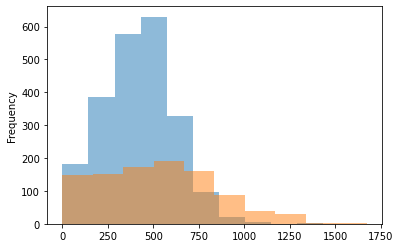

In [16]:
data['sum_min'][data['tariff'] == 'smart'].plot(kind='hist', alpha=0.5)
data['sum_min'][data['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5)

На графике видно, что распределение у тарифов 'smart' и 'ultra' отличается. У первого оно близко к нормальному, но имеет скошенность вправо, у второго также наблюдается скошеность вправо, но оно более равномерное, не имеет чёткого пика, как при нормальном распределении.

<AxesSubplot:ylabel='Frequency'>

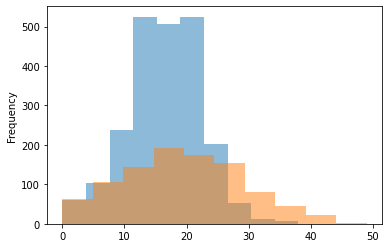

In [17]:
data['sum_internet'][data['tariff'] == 'smart'].plot(kind='hist', alpha=0.5)
data['sum_internet'][data['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5)

На графике видно, что распределение у тарифа 'smart' близко к нормальному, также как и у 'ultra', но у него оно более равномерное, можно предположить, что количество людей с тарифом 'ultra' меньше, чем с другим тарифом.

<AxesSubplot:ylabel='Frequency'>

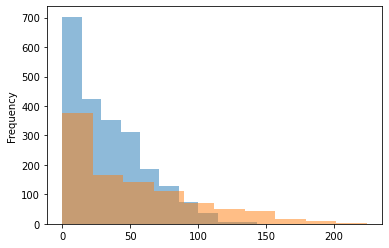

In [18]:
data['count_messages'][data['tariff'] == 'smart'].plot(kind='hist', alpha=0.5)
data['count_messages'][data['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5)

На графике мы видим, что распределение у этих тарифов практически одинаковое, а именно распределение с положительной ассиметрией, но у тарифа 'ultra' ассиметрия вправо больше, чем у 'smart'.

## Шаг 4. Составление и проверка гипотез

На данном этапе мы должны проверить наши гиуотезы по поводу того, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Нашей Н0 станет гипотеза, которая звучит так: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются". Альтернативная же гипотеза будет звучать так: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

Для проверки данной гипотезы мы будет использовать t-тест, поскольку выборки у нас независимые.

In [19]:
smart = data.query('tariff == "smart"')
ultra = data.query('tariff == "ultra"')
alpha = 0.05
results = st.ttest_ind(smart['income'], ultra['income'])

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.096430794562863e-119
Отвергаем нулевую гипотезу


В процессе проверки гипотез мы пришли к выводу, что нулевую гипотезу придётся отвергунть, так как её P уровень значимости оказался меньше 5%. То есть вероятность такого события при верной нулевой гипотезе признаётся слишком малой, значит, у нас есть основание отвергнуть нулевую гипотезу. 

Для того, чтобы результат стал нагляднее - выведем среднюю выручку пользователей по тарифам.

In [20]:
print(smart['income'].mean())
ultra['income'].mean()

1237.5733512786003


1950.0

Теперь мы видим, что средняя выручка по тарифу 'ultra' куда больше, чем выручка по тарифу 'smart'.

Теперь проверим вторую гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Нулевая гипотеза будет звучать так: "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов", а альтернативная гипотеза будет звучать следующим образом: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов."

Для проверки данной гипотезы мы будет использовать t-тест, поскольку выборки у нас независимые.

In [21]:
tariffs_msk = data.query('city == "Москва"')
tariffs_not_msk = data.query('city != "Москва"')
alpha = 0.05
results = st.ttest_ind(tariffs_msk['income'], tariffs_not_msk['income'])

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6213003786524719
Не получилось отвергнуть нулевую гипотезу


В процессе проверки гипотез мы пришли к выводу, что нулевую гипотезу не получится отвергунть, так как её P уровень значимости оказался меньше 5%. Это значит, что вероятность того, что измеренное эмпирически значение окажется далеко от среднего равна меньше 5%. То есть вероятность Н0 при верной нулевой гипотезе признаётся высокой, значит, у нас есть основание не отвергнуть нулевую гипотезу.

## Шаг 5. Общий вывод

Мы проделали огромную работу в процессе изучения этого кейса. Мы обработали имеющиеся данные, рассчитали средний доход с каждого тарифа для каждого пользователя, это помогло нам в дальнейшем исследовании, ведь на их основе мы проверяли наши гипотезы(было составлено две нулевых и две альтернативных гипотезы). По ним мы получили следующие результаты:

Гипотеза о том, что средняя выручка пользователей тарифов Ультра не отличается от выручки пользователей Тарифа смарт отвергнута, поскольку в результате исследований мы узнали, что P уровень значимости оказался меньше 5%. То есть вероятность такого события при верной нулевой гипотезе признаётся слишком малой, значит, у нас есть основание отвергнуть нулевую гипотезу. 

Гипотеза о том, что выручка пользователей из Москвы равна не отличается от выручки пользователей из других регионов не отвергнута. Поскольку её P уровень значимости оказался меньше 5%. Это значит, что вероятность того, что измеренное эмпирически значение окажется далеко от среднего равна меньше 5%. То есть вероятность Н0 при верной нулевой гипотезе признаётся высокой, значит, у нас есть основание не отвергнуть нулевую гипотезу.